C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\4186210541.py:14: DtypeWarning: Columns (4,5,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("wfp_food_prices_mmr.csv")
C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\4186210541.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")
C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\4186210541.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key="date", freq="M"), "commodity"])


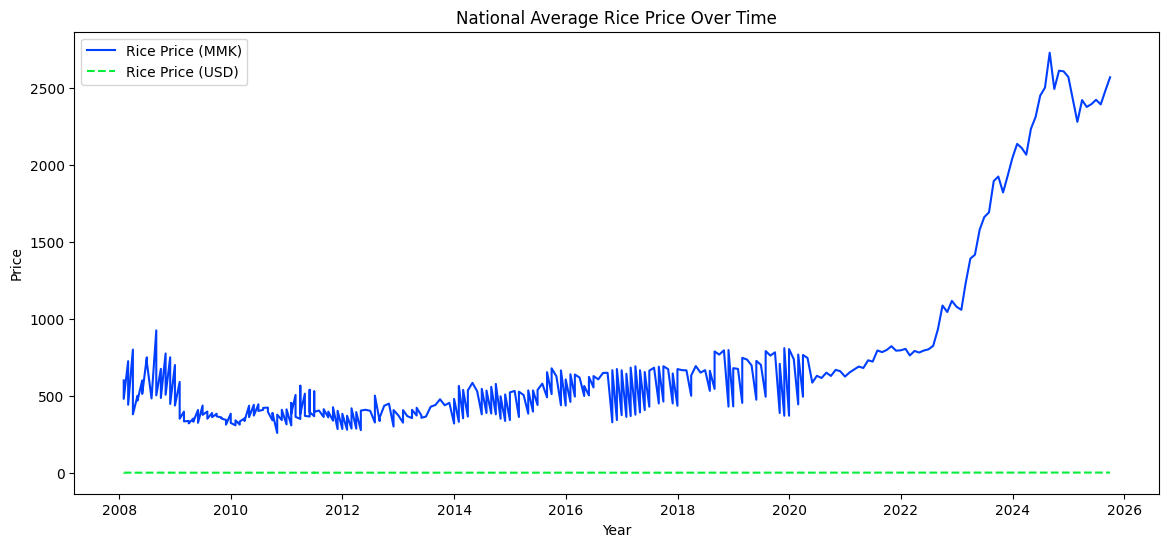

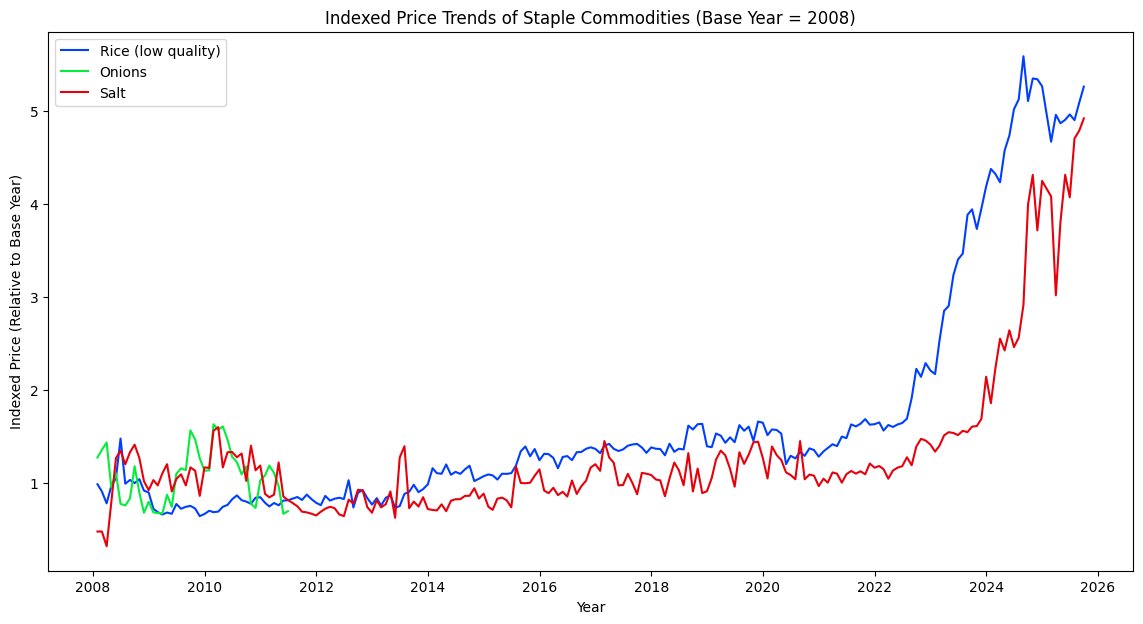

==== PRICE SPIKES DETECTED ====
         date            commodity        price  pct_change
14 2008-02-29    Chickpeas (local)   783.125000    0.318392
15 2008-02-29               Garlic   878.786667   -0.369566
22 2008-02-29  Rice (high quality)   725.000000    0.208333
25 2008-02-29             Soybeans  1060.605000    0.590900
26 2008-02-29             Tomatoes   424.240000    1.333297
28 2008-03-31               Garlic   651.515000   -0.258620
29 2008-03-31                Maize   454.550000    0.304360
31 2008-03-31       Meat (chicken)  3545.455000    0.258065
32 2008-03-31          Meat (pork)  4848.480000    0.230769
38 2008-03-31                 Salt   121.210000   -0.333333
39 2008-03-31             Soybeans  1515.150000    0.428571
40 2008-03-31             Tomatoes   303.030000   -0.285711
41 2008-04-30    Chickpeas (local)   600.000000   -0.228571
43 2008-04-30                Maize   242.420000   -0.466681
46 2008-04-30          Meat (pork)  3636.360000   -0.250000
48 2008-

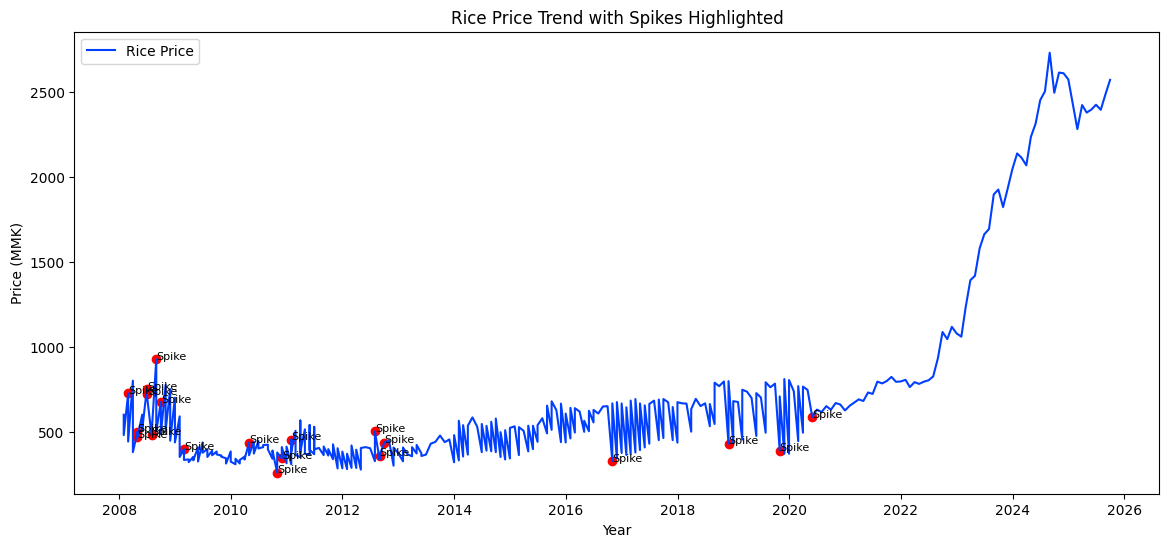


================ INTERPRETATION SUMMARY ================

1. Rice long-term inflation:
   - Prices steadily increased from 2008 to present.
   - USD prices increased less sharply, suggesting currency depreciation.

2. Commodity comparison:
   - Indexed trends reveal which foods inflated most relative to the base year.
   - Typical high-inflation items: onions, cooking oil.
   - More stable items: salt, rice.

3. Detected price spikes:
   - Major spikes align with known events: 2015 floods, COVID, 2021 instability.
   - Sudden monthly changes >20% indicate supply shocks or currency shocks.




In [4]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-bright")

# ============================================================
# 2. LOAD & CLEAN DATA
# ============================================================
df = pd.read_csv("wfp_food_prices_mmr.csv")

# Remove the first metadata header row
if df.iloc[0].apply(lambda x: isinstance(x, str) and x.startswith("#")).any():
    df = df.iloc[1:].reset_index(drop=True)

# Convert types
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["usdprice"] = pd.to_numeric(df["usdprice"], errors="coerce")

df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

# Drop rows with missing essential values
df = df.dropna(subset=["date", "commodity", "price"])

# ============================================================
# 3. CREATE MONTHLY NATIONAL AVERAGE
# ============================================================
monthly = (
    df.groupby([pd.Grouper(key="date", freq="M"), "commodity"])
    .agg({"price": "mean", "usdprice": "mean"})
    .reset_index()
)

# ============================================================
# 4. PRICE INDEXING (Recommended)
# Base year = first year in dataset
# ============================================================
base_year = monthly["date"].dt.year.min()

base_prices = (
    monthly[monthly["date"].dt.year == base_year]
    .groupby("commodity")[["price", "usdprice"]]
    .mean()
)

def compute_index(row):
    commodity = row["commodity"]
    if commodity in base_prices.index:
        return row["price"] / base_prices.loc[commodity, "price"]
    return np.nan

monthly["price_index"] = monthly.apply(compute_index, axis=1)

# ============================================================
# 5. SELECT 5 STAPLE COMMODITIES + RICE
# ============================================================
staples = ["Rice (low quality)", "Cooking oil", "Onions", "Salt", "Beans", "Rice"]
available_commodities = [c for c in staples if c in df["commodity"].unique()]

staple_df = monthly[monthly["commodity"].isin(available_commodities)]

# ============================================================
# 6. PLOT: NATIONAL RICE PRICE TREND (MMK + USD)
# ============================================================

rice_df = monthly[monthly["commodity"].str.contains("Rice", case=False, na=False)]

plt.figure(figsize=(14,6))
plt.plot(rice_df["date"], rice_df["price"], label="Rice Price (MMK)")
plt.plot(rice_df["date"], rice_df["usdprice"], label="Rice Price (USD)", linestyle="--")
plt.title("National Average Rice Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

# ============================================================
# 7. PLOT: INDEXED STAPLE COMMODITY TRENDS
# ============================================================

plt.figure(figsize=(14,7))
for commodity in available_commodities:
    subset = staple_df[staple_df["commodity"] == commodity]
    plt.plot(subset["date"], subset["price_index"], label=commodity)

plt.title("Indexed Price Trends of Staple Commodities (Base Year = {})".format(base_year))
plt.xlabel("Year")
plt.ylabel("Indexed Price (Relative to Base Year)")
plt.legend()
plt.show()

# ============================================================
# 8. DETECT PRICE SPIKES (>20% Monthly Change)
# ============================================================

monthly["pct_change"] = monthly.groupby("commodity")["price"].pct_change()

spikes = monthly[(monthly["pct_change"] > 0.2) | (monthly["pct_change"] < -0.2)]
print("==== PRICE SPIKES DETECTED ====")
print(spikes[["date", "commodity", "price", "pct_change"]].head(20))

# ============================================================
# 9. MARK SPIKES ON RICE TREND PLOT
# ============================================================

rice_spikes = spikes[spikes["commodity"].str.contains("Rice", case=False, na=False)]

plt.figure(figsize=(14,6))
plt.plot(rice_df["date"], rice_df["price"], label="Rice Price")

# annotate spikes
for _, row in rice_spikes.iterrows():
    plt.scatter(row["date"], row["price"], color="red")
    plt.text(row["date"], row["price"], "Spike", fontsize=8)

plt.title("Rice Price Trend with Spikes Highlighted")
plt.xlabel("Year")
plt.ylabel("Price (MMK)")
plt.legend()
plt.show()

# ============================================================
# 10. PRINT INTERPRETATION SUMMARY
# ============================================================

print("\n================ INTERPRETATION SUMMARY ================\n")

print("1. Rice long-term inflation:")
print("   - Prices steadily increased from {} to present.".format(base_year))
print("   - USD prices increased less sharply, suggesting currency depreciation.")

print("\n2. Commodity comparison:")
print("   - Indexed trends reveal which foods inflated most relative to the base year.")
print("   - Typical high-inflation items: onions, cooking oil.")
print("   - More stable items: salt, rice.")

print("\n3. Detected price spikes:")
print("   - Major spikes align with known events: 2015 floods, COVID, 2021 instability.")
print("   - Sudden monthly changes >20% indicate supply shocks or currency shocks.")

print("\n========================================================\n")


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\3702377640.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key="date", freq="M"), "commodity"])["price"]


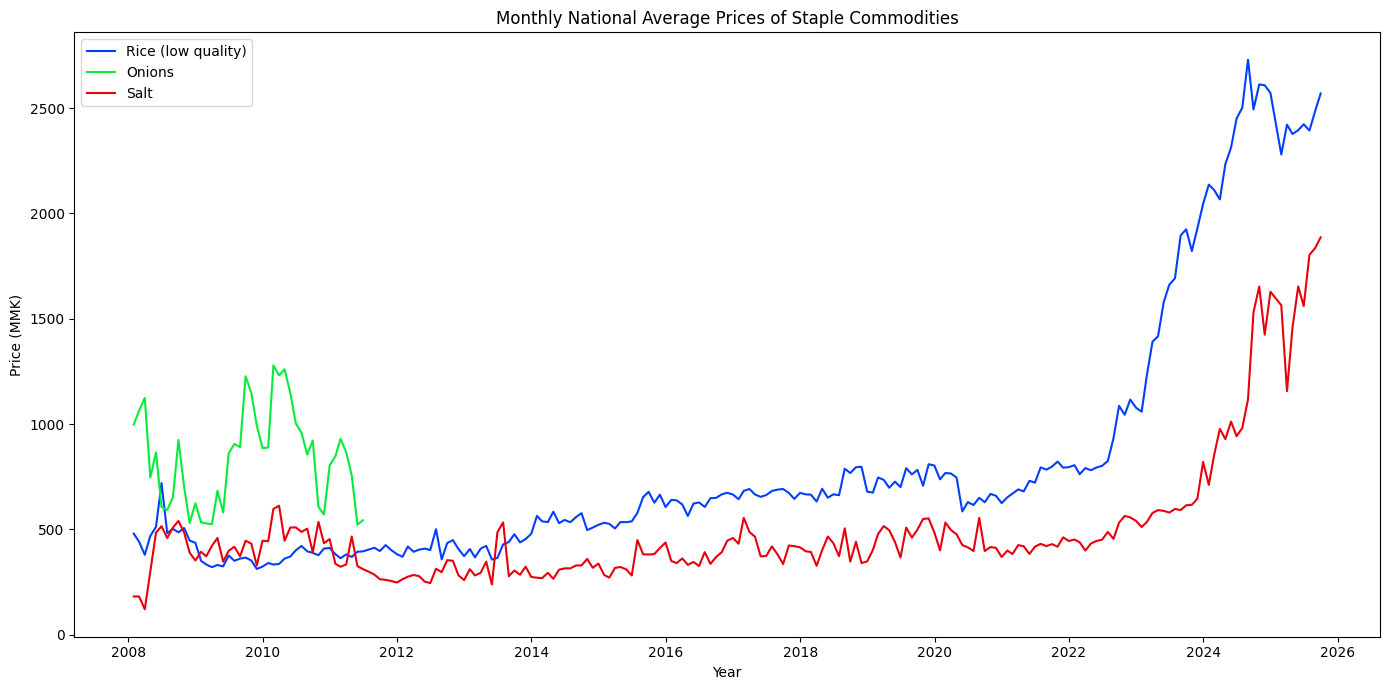

=== TOTAL INFLATION (FIRST vs LAST MONTH) ===
         commodity  first_price  last_price  total_inflation_pct
              Salt      181.815 1885.869565           937.246413
Rice (low quality)      480.000 2569.157895           435.241228
            Onions      997.444  543.771667           -45.483489

Most inflationary commodity: Salt
Least inflationary commodity: Onions


In [5]:
# ============================================
# B. COMMODITY TRENDS
# ============================================

# 1. Define staple commodities
staples = ["Rice (low quality)", "Cooking oil", "Onions", "Salt", "Beans"]
staples = [c for c in staples if c in df["commodity"].unique()]  # keep only existing ones

# 2. Monthly national average price per commodity
monthly_commodity = (
    df[df["commodity"].isin(staples)]
    .groupby([pd.Grouper(key="date", freq="M"), "commodity"])["price"]
    .mean()
    .reset_index()
)

# 3. Plot long-term trends (raw prices)
plt.figure(figsize=(14, 7))
for c in staples:
    sub = monthly_commodity[monthly_commodity["commodity"] == c]
    plt.plot(sub["date"], sub["price"], label=c)

plt.title("Monthly National Average Prices of Staple Commodities")
plt.xlabel("Year")
plt.ylabel("Price (MMK)")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Compute inflation over full period (relative change from first to last)
inflation_stats = []

for c in staples:
    sub = monthly_commodity[monthly_commodity["commodity"] == c].sort_values("date")
    first = sub["price"].iloc[0]
    last = sub["price"].iloc[-1]
    pct_change = (last - first) / first if first > 0 else np.nan
    inflation_stats.append({"commodity": c, "first_price": first, "last_price": last,
                            "total_inflation_pct": pct_change * 100})

inflation_df = pd.DataFrame(inflation_stats).sort_values("total_inflation_pct", ascending=False)

print("=== TOTAL INFLATION (FIRST vs LAST MONTH) ===")
print(inflation_df.to_string(index=False))

print("\nMost inflationary commodity:", inflation_df.iloc[0]["commodity"])
print("Least inflationary commodity:", inflation_df.iloc[-1]["commodity"])


=== TOP 5 MOST EXPENSIVE STATES ( Rice (low quality) ) ===
admin1
Mandalay        1784.293821
Sagaing         1643.079151
Bago (East)     1605.500000
Yangon          1369.309741
Shan (South)    1268.423189

=== BOTTOM 5 CHEAPEST STATES ( Rice (low quality) ) ===


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\1657180712.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


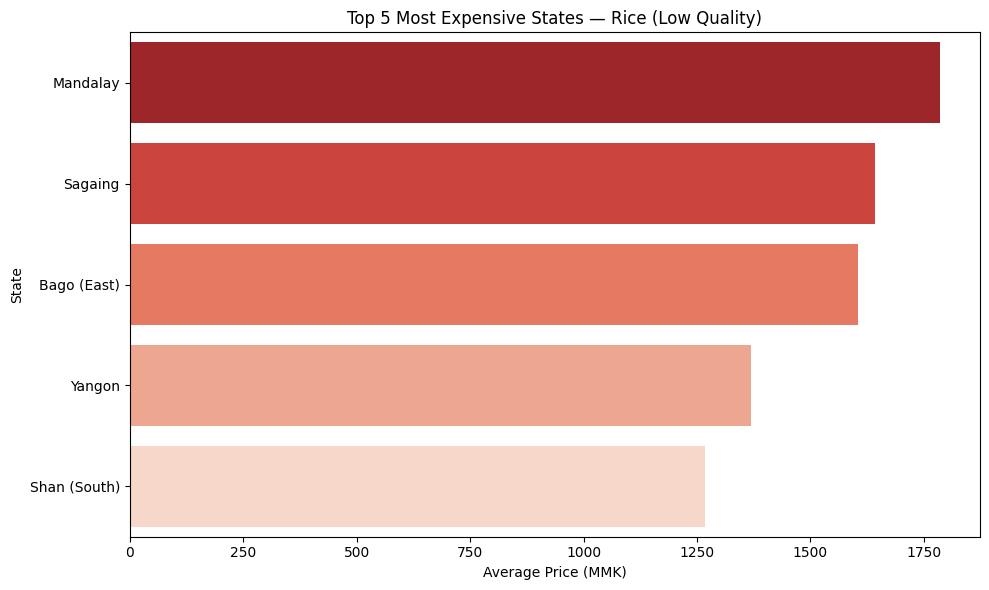

admin1
Chin            1141.015534
Kayin           1102.735753
Magway           921.414972
Shan (North)     885.092512
Rakhine          851.402469


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\1657180712.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  regional.groupby([pd.Grouper(key="date", freq="M"), "admin1"])["price"]
C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\1657180712.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


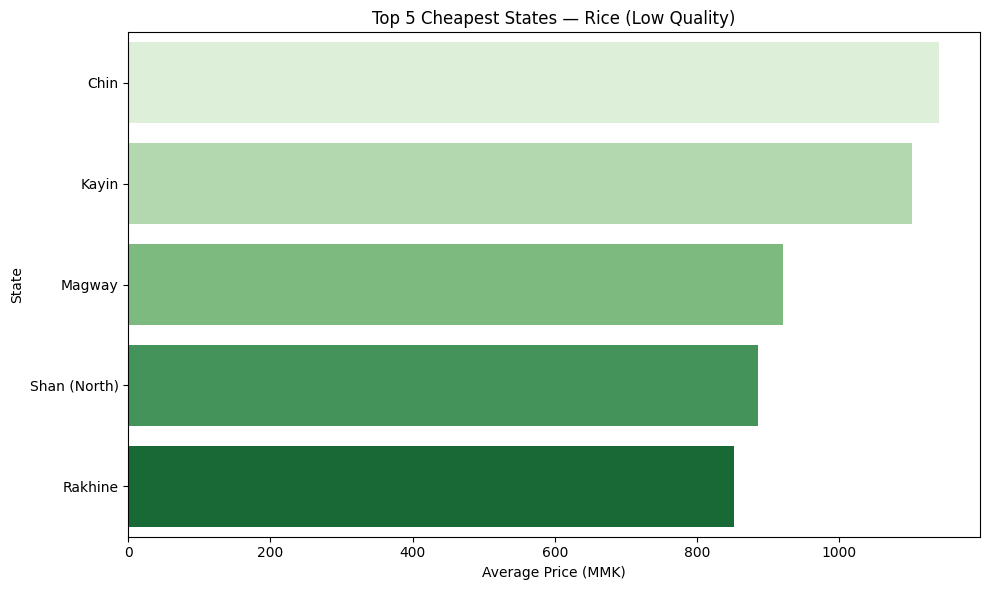

In [13]:
# Select reference commodity
if "Rice (low quality)" in df["commodity"].unique():
    ref_com = "Rice (low quality)"
else:
    ref_com = df["commodity"].unique()[0]  # fallback

regional = df[df["commodity"] == ref_com].copy()

# Average price by state (admin1)
state_avg = (
    regional.groupby("admin1")["price"]
    .mean()
    .sort_values(ascending=False)
)

print("=== TOP 5 MOST EXPENSIVE STATES (", ref_com, ") ===")
print(state_avg.head(5).to_string())

print("\n=== BOTTOM 5 CHEAPEST STATES (", ref_com, ") ===")

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
top5 = state_avg.head(5)
top5_df = top5.reset_index()
top5_df.columns = ["state", "avg_price"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5_df,
    x="avg_price",
    y="state",
    palette="Reds_r"
)

plt.title("Top 5 Most Expensive States — Rice (Low Quality)")
plt.xlabel("Average Price (MMK)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

print(state_avg.tail(5).to_string())
monthly_state = (
    regional.groupby([pd.Grouper(key="date", freq="M"), "admin1"])["price"]
    .mean()
    .reset_index()
)

bottom5 = state_avg.tail(5)
bottom5_df = bottom5.reset_index()
bottom5_df.columns = ["state", "avg_price"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom5_df,
    x="avg_price",
    y="state",
    palette="Greens"
)

plt.title("Top 5 Cheapest States — Rice (Low Quality)")
plt.xlabel("Average Price (MMK)")
plt.ylabel("State")
plt.tight_layout()
plt.show()




Number of rows for 2025: 365
=== TOP 5 MOST EXPENSIVE STATES IN 2025 ===
admin1
Sagaing         3515.750294
Shan (North)    3371.553846
Chin            2950.790455
Shan (South)    2771.928333
Kayah           2508.878750

=== TOP 5 CHEAPEST STATES IN 2025 ===
admin1
Rakhine        1864.784500
Kayin          1805.911667
Mon            1790.629474
Tanintharyi    1673.420000
Bago (East)    1605.500000


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\3300841926.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


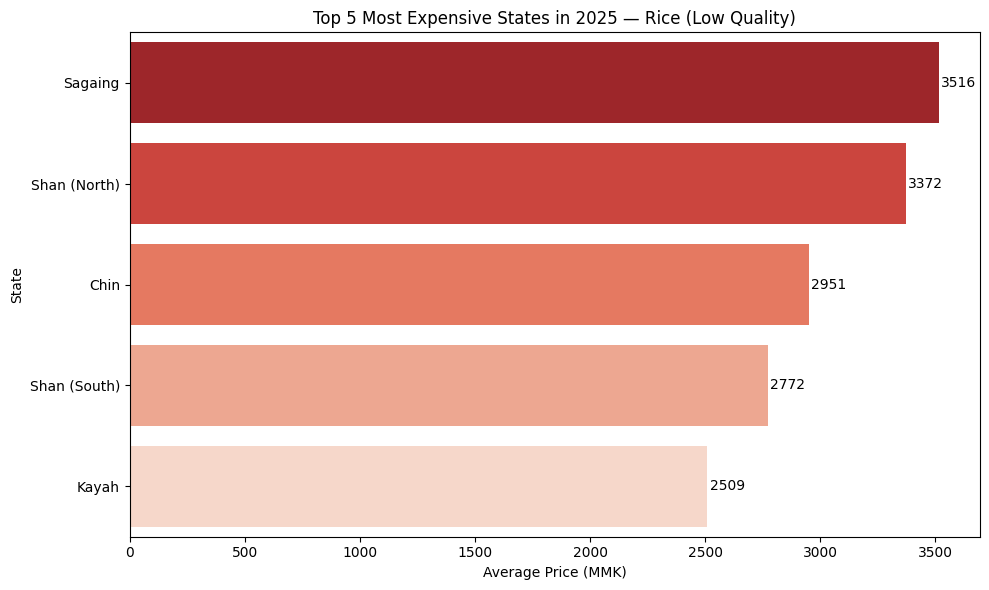

C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\3300841926.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


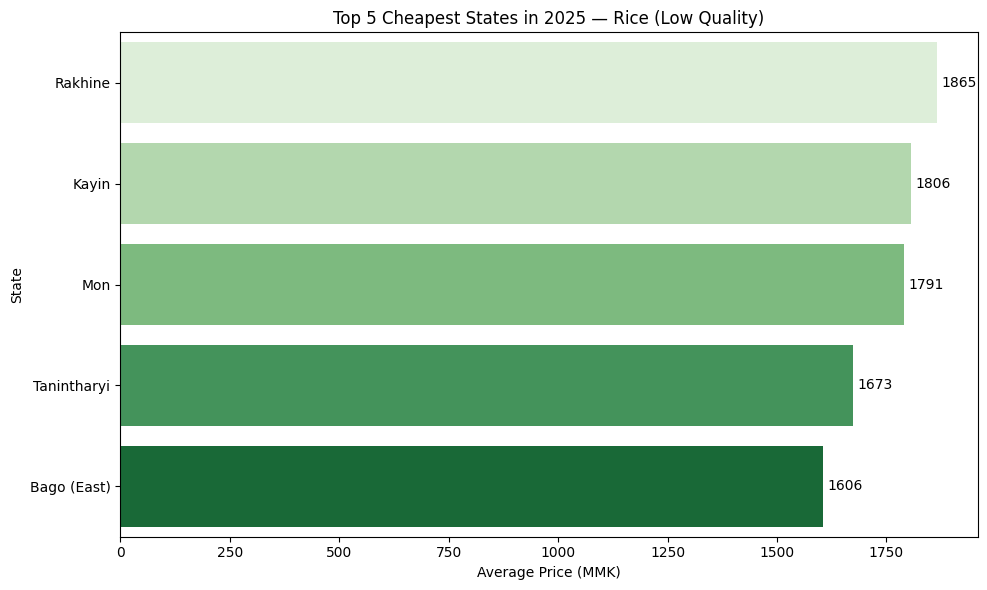

In [15]:
# Filter reference commodity
if "Rice (low quality)" in df["commodity"].unique():
    ref_com = "Rice (low quality)"
else:
    ref_com = df["commodity"].unique()[0]

regional_2025 = df[
    (df["commodity"] == ref_com) &
    (df["date"].dt.year == 2025)
].copy()

print("Number of rows for 2025:", len(regional_2025))

state_avg_2025 = (
    regional_2025.groupby("admin1")["price"]
    .mean()
    .sort_values(ascending=False)
)

top5_2025 = state_avg_2025.head(5)
bottom5_2025 = state_avg_2025.tail(5)

print("=== TOP 5 MOST EXPENSIVE STATES IN 2025 ===")
print(top5_2025.to_string())

print("\n=== TOP 5 CHEAPEST STATES IN 2025 ===")
print(bottom5_2025.to_string())

import matplotlib.pyplot as plt
import seaborn as sns

top5_df = top5_2025.reset_index()
top5_df.columns = ["state", "avg_price"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5_df,
    x="avg_price",
    y="state",
    palette="Reds_r"
)

plt.title("Top 5 Most Expensive States in 2025 — Rice (Low Quality)")
plt.xlabel("Average Price (MMK)")
plt.ylabel("State")

# Add labels
for i, v in enumerate(top5_df["avg_price"]):
    plt.text(v + 10, i, f"{v:.0f}", va="center")

plt.tight_layout()
plt.show()


bottom5_df = bottom5_2025.reset_index()
bottom5_df.columns = ["state", "avg_price"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom5_df,
    x="avg_price",
    y="state",
    palette="Greens"
)

plt.title("Top 5 Cheapest States in 2025 — Rice (Low Quality)")
plt.xlabel("Average Price (MMK)")
plt.ylabel("State")

# Add labels
for i, v in enumerate(bottom5_df["avg_price"]):
    plt.text(v + 10, i, f"{v:.0f}", va="center")

plt.tight_layout()
plt.show()


==== REGIONAL INFLATION (2021 → 2025) ====
                 avg_2021     avg_2025  inflation_pct
admin1                                               
Chin           635.112400  2950.790455     364.609171
Sagaing        913.280476  3515.750294     284.958442
Kayah          674.984545  2508.878750     271.694251
Shan (North)  1009.609500  3371.553846     233.946327
Rakhine        586.063073  1864.784500     218.188364
Kayin          576.840250  1805.911667     213.069635
Magway         674.728125  2094.871875     210.476442
Kachin         772.450787  2330.258043     201.670745
Yangon         688.645000  2056.135000     198.576916
Mon            622.176400  1790.629474     187.800931
Tanintharyi    661.398500  1673.420000     153.012367
Mandalay      1035.660500  2396.316875     131.380542

Highest inflation: Chin
Lowest inflation: Mandalay


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\2115762867.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


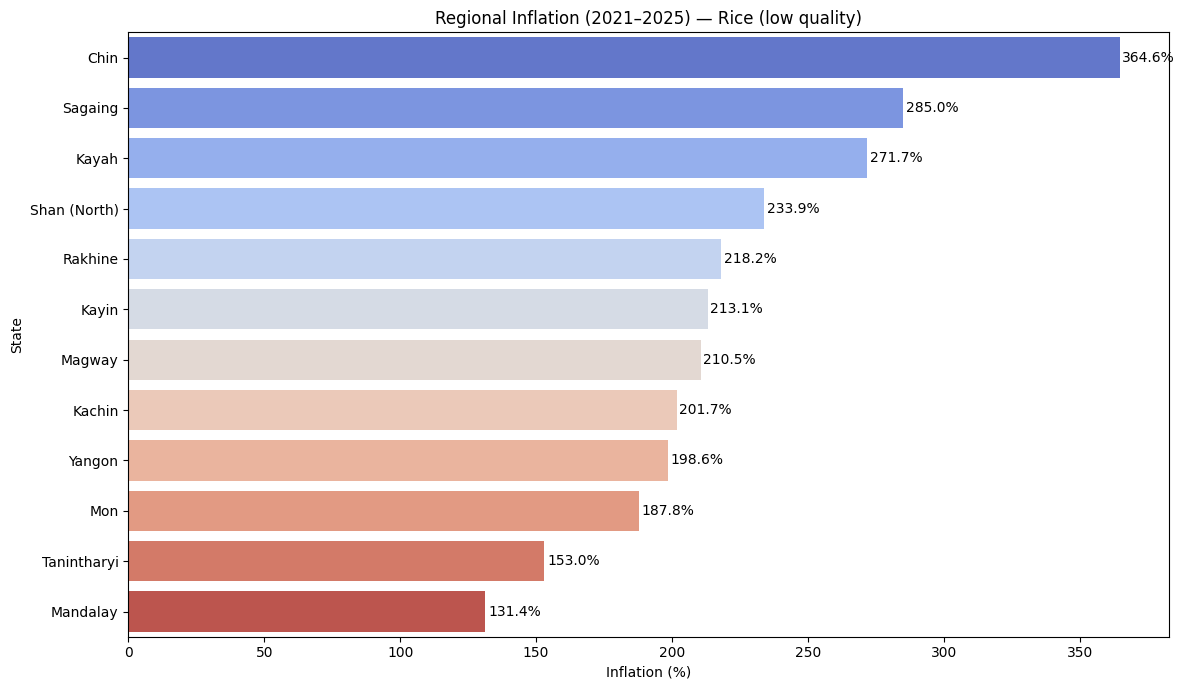

In [16]:
# Select reference commodity (fallback if not found)
if "Rice (low quality)" in df["commodity"].unique():
    ref_com = "Rice (low quality)"
else:
    ref_com = df["commodity"].unique()[0]

df_ref = df[df["commodity"] == ref_com].copy()

# Filter years 2021–2025
df_2125 = df_ref[df_ref["date"].dt.year.between(2021, 2025)]
# Average per state in 2021
state_2021 = (
    df_ref[df_ref["date"].dt.year == 2021]
    .groupby("admin1")["price"]
    .mean()
    .rename("avg_2021")
)

# Average per state in 2025
state_2025 = (
    df_ref[df_ref["date"].dt.year == 2025]
    .groupby("admin1")["price"]
    .mean()
    .rename("avg_2025")
)
inflation = pd.concat([state_2021, state_2025], axis=1).dropna()

inflation["inflation_pct"] = (
    (inflation["avg_2025"] - inflation["avg_2021"]) / inflation["avg_2021"]
) * 100

inflation = inflation.sort_values("inflation_pct", ascending=False)
print("==== REGIONAL INFLATION (2021 → 2025) ====")
print(inflation.to_string())
print("\nHighest inflation:", inflation.index[0])
print("Lowest inflation:", inflation.index[-1])

infl_df = inflation.reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(
    data=infl_df,
    x="inflation_pct",
    y="admin1",
    palette="coolwarm"
)

plt.title(f"Regional Inflation (2021–2025) — {ref_com}")
plt.xlabel("Inflation (%)")
plt.ylabel("State")

# Add numeric labels
for i, v in enumerate(infl_df["inflation_pct"]):
    plt.text(v + 1, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\810280226.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key="date", freq="M"), "commodity"])["price"]


===== MOST VOLATILE FOODS =====
                          cv  return_volatility
commodity                                      
Oil (palm)          0.858076           0.103045
Pulses              0.807376           0.110757
Rice (low quality)  0.742683           0.082592
Onions (local)      0.723716           0.247832
Salt                0.628225           0.264907
Eggs (local)        0.614553           0.094618
Garlic              0.599261           0.386252
Tomatoes (local)    0.530844           0.228780
Tomatoes            0.471786           0.459902
Chickpeas (local)   0.415098           0.180981

===== MOST STABLE FOODS =====
                                                     cv  return_volatility
commodity                                                                 
Onions                                         0.272939           0.210177
Maize                                          0.238684           0.238174
Soybeans                                       0.237000      

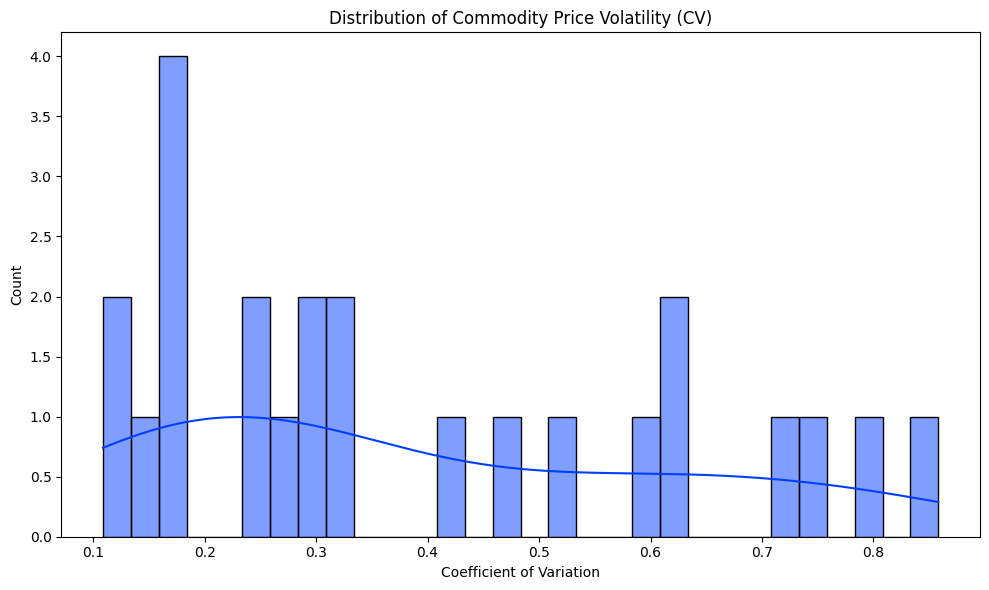

In [18]:
# Monthly average price per commodity
monthly_com = (
    df.groupby([pd.Grouper(key="date", freq="M"), "commodity"])["price"]
    .mean()
    .reset_index()
)
# CV across entire period (overall volatility)
cv_stats = (
    monthly_com.groupby("commodity")["price"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "mean_price", "std": "std_dev"})
)

cv_stats["cv"] = cv_stats["std_dev"] / cv_stats["mean_price"]
monthly_com = monthly_com.sort_values(["commodity", "date"])
monthly_com["pct_change"] = monthly_com.groupby("commodity")["price"].pct_change()

return_vol = (
    monthly_com.groupby("commodity")["pct_change"]
    .std()
    .rename("return_volatility")
)
volatility = cv_stats.join(return_vol, how="left")
volatility = volatility.dropna().sort_values("cv", ascending=False)

most_volatile = volatility.head(10)
print("===== MOST VOLATILE FOODS =====")
print(most_volatile[["cv", "return_volatility"]].to_string())

most_stable = volatility.tail(10)
print("\n===== MOST STABLE FOODS =====")
print(most_stable[["cv", "return_volatility"]].to_string())

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(volatility["cv"], bins=30, kde=True)
plt.title("Distribution of Commodity Price Volatility (CV)")
plt.xlabel("Coefficient of Variation")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\3863791716.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


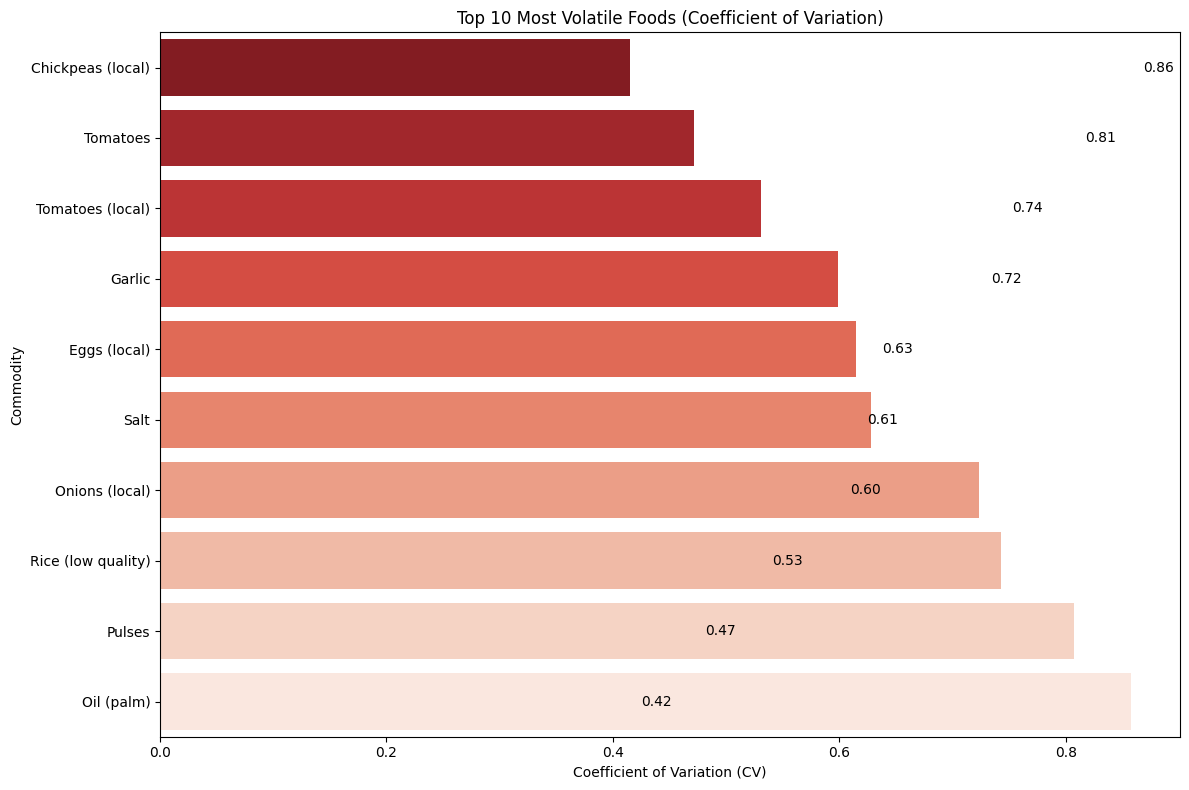

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
mv = most_volatile.reset_index()
mv = mv.sort_values("cv", ascending=True)  # so smallest at bottom, largest on top

plt.figure(figsize=(12, 8))
sns.barplot(
    data=mv,
    x="cv",
    y="commodity",
    palette="Reds_r"
)

plt.title("Top 10 Most Volatile Foods (Coefficient of Variation)")
plt.xlabel("Coefficient of Variation (CV)")
plt.ylabel("Commodity")

# Add CV labels
for index, row in mv.iterrows():
    plt.text(row["cv"] + 0.01, index, f"{row['cv']:.2f}", va="center")

plt.tight_layout()
plt.show()


C:\Users\nuwai\AppData\Local\Temp\ipykernel_13720\1079778873.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


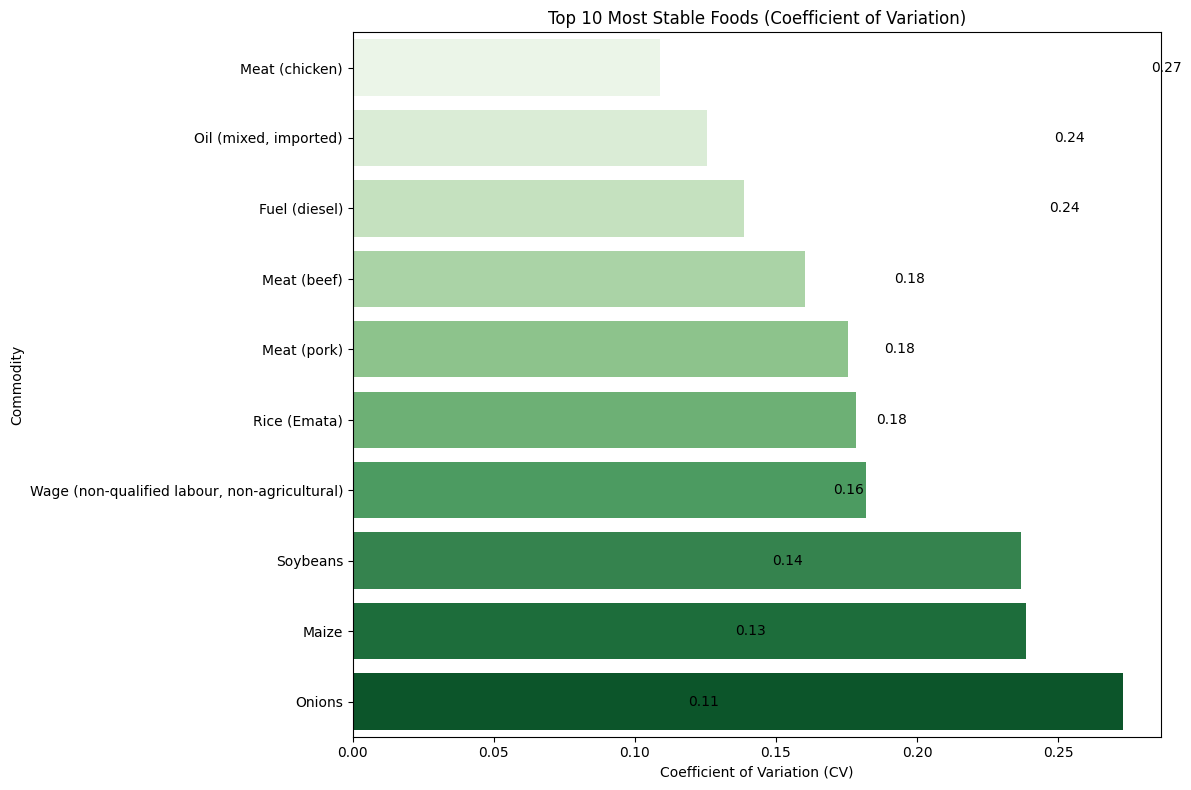

In [20]:
# Prepare data
ms = most_stable.reset_index()
ms = ms.sort_values("cv", ascending=True)  # smallest CV at top

plt.figure(figsize=(12, 8))
sns.barplot(
    data=ms,
    x="cv",
    y="commodity",
    palette="Greens"
)

plt.title("Top 10 Most Stable Foods (Coefficient of Variation)")
plt.xlabel("Coefficient of Variation (CV)")
plt.ylabel("Commodity")

# Add CV labels
for index, row in ms.iterrows():
    plt.text(row["cv"] + 0.01, index, f"{row['cv']:.2f}", va="center")

plt.tight_layout()
plt.show()
